<a href="https://colab.research.google.com/github/charlottejin95/Click_through_rate_prediction/blob/main/Click_Through_Rate_Prediction_Wide_and_Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTR Prediction

##Environment Setup

pip install dask[dataframe] --upgrade

!pip install scikit-learn==1.0.2

!pip install xgboost --upgrade

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dask_data

import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

import sklearn
import matplotlib.dates as mdates
matplotlib.style.use('ggplot')

#A parse date variable to pass in the read_csv function later to take into account the date format
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Data ETL and Data Exploration

The Data set used in this analysis is **Kaggle Click-Through Rate Prediction competation sponsored by Avazu**. The goal is to determine the probability of whether someone would click on a mobile ad or not based on 10 days of their data. Due to the computation constrain, in this project, I use a sample of 100k rows from the dataset.

Data set used: [CTR Predcition dataset](https://www.kaggle.com/c/avazu-ctr-prediction/overview)

In [3]:
# A sample dataset of 100k lines.
!ls '/content/drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/CTR(Click through rate) Prediction'

# def parse_date(date):
#     return pd.to_datetime(date, format='%y%m%d%H')

parse_date='%y%m%d%H'

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/CTR(Click through rate) Prediction/filtered_train.csv',
                         parse_dates = ['hour'], date_format=parse_date, nrows = 100000)

'Click Through Rate Prediction'
'CTR Project Todo--improve'
 CTR--Pytorch_wide_and_deep.ipynb
 filtered_train.csv
'Original Version -- CTR Project Todo'
'Original Version--pytorch_wide_and_deep.ipynb'


In [4]:
train_data.head(3)

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,2014-10-21 01:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,...,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,2014-10-21 03:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,2014-10-21 03:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17614,320,50,1993,2,1063,-1,33


**Feature included in this data set:**

 `id`: ad identifier\
`click`: 0/1 for non-click/click\
`hour`: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.\
`C1`: anonymized categorical variable\
`C14-C21`: anonymized categorical variables\
`banner_pos`, `site_id`, `site_domain`, `site_category`, `app_id`, `app_domain`, `app_category`,\
 `device_id`, `device_ip`, `device_model`, `device_type`, `device_conn_type`


#### General Data Description

In [5]:
train_data.info()
train_data_clicks = train_data[train_data['click']==1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        100000 non-null  int64         
 1   id                100000 non-null  float64       
 2   click             100000 non-null  int64         
 3   hour              100000 non-null  datetime64[ns]
 4   C1                100000 non-null  int64         
 5   banner_pos        100000 non-null  int64         
 6   site_id           100000 non-null  object        
 7   site_domain       100000 non-null  object        
 8   site_category     100000 non-null  object        
 9   app_id            100000 non-null  object        
 10  app_domain        100000 non-null  object        
 11  app_category      100000 non-null  object        
 12  device_id         100000 non-null  object        
 13  device_ip         100000 non-null  object        
 14  devic

In [6]:
train_data.iloc[:,2:].describe()


,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.166530,2014-10-22 01:36:54.720000,1004.982610,0.256050,1.017630,0.241970,18490.707470,317.961280,59.130140,2083.369360,1.315670,177.618200,49145.389770,93.558420
min,0.000000,2014-10-21 00:00:00,1001.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,0.000000,2014-10-21 12:00:00,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,33.000000
50%,0.000000,2014-10-22 05:00:00,1005.000000,0.000000,1.000000,0.000000,20352.000000,320.000000,50.000000,2333.000000,0.000000,39.000000,-1.000000,79.000000
75%,0.000000,2014-10-22 12:00:00,1005.000000,1.000000,1.000000,0.000000,21759.000000,320.000000,50.000000,2502.000000,3.000000,167.000000,100084.000000,157.000000
max,1.000000,2014-10-23 04:00:00,1012.000000,7.000000,5.000000,5.000000,22118.000000,1024.000000,1024.000000,2547.000000,3.000000,1835.000000,100248.000000,221.000000
std,0.372558,NaN,1.000549,0.459272,0.489961,0.707662,4857.861307,25.627016,47.026765,592.502179,1.380312,324.085017,50047.403239,67.464087


#### Data EDA

##### Analysis on: the number of clicks

The percentage of clicks and no-clicks are:


,count
click,
0,0.83347
1,0.16653


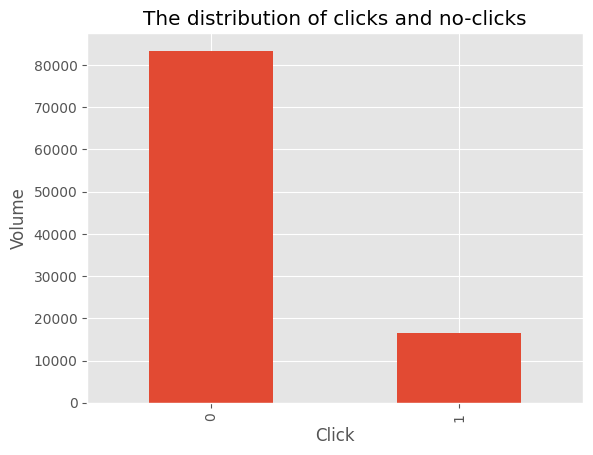

In [7]:
# Click v/s No click distribution
train_data.groupby('click').size().plot(kind = 'bar')
plt.xlabel('Click')
plt.ylabel('Volume')
plt.title('The distribution of clicks and no-clicks')

rows = train_data.shape[0]
click_through_rate = train_data['click'].value_counts()/rows

print('The percentage of clicks and no-clicks are:')
click_through_rate

Note: The data is highly imbalanced. There are only 16% clicks.

##### Analysis on date & time

In [8]:
#hour
train_data['hour'].describe()

,hour
count,100000
mean,2014-10-22 01:36:54.720000
min,2014-10-21 00:00:00
25%,2014-10-21 12:00:00
50%,2014-10-22 05:00:00
75%,2014-10-22 12:00:00
max,2014-10-23 04:00:00


The percentage of volume by day:


,count
hour,
2014-10-21,0.41178
2014-10-22,0.53443
2014-10-23,0.05379


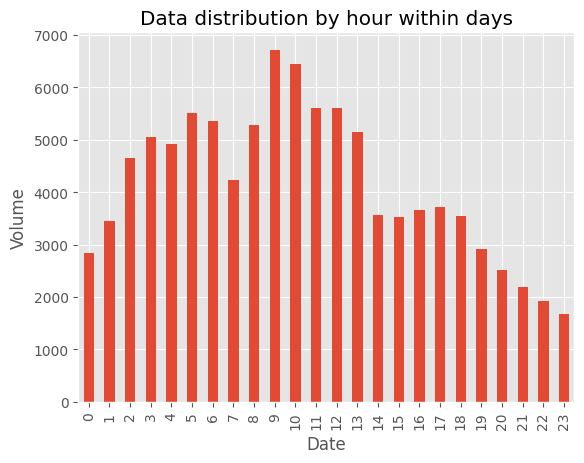

In [9]:
train_data['hour'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Data distribution by hour within days')

print('The percentage of volume by day:')
train_data['hour'].dt.date.value_counts().sort_index()/rows

##### Analysis on: banner position

Banner positions representing attractiveness and appealing designs, which can highly impact user's behavior and their decision to click or not.
It's an effective metric to predict clicks

The number of clicks by different banner positions


id       
click           0      1
banner_pos              
0           62566  12209
1           20691   4424
2              26      4
4              17      1
5              35      3
7              12     12

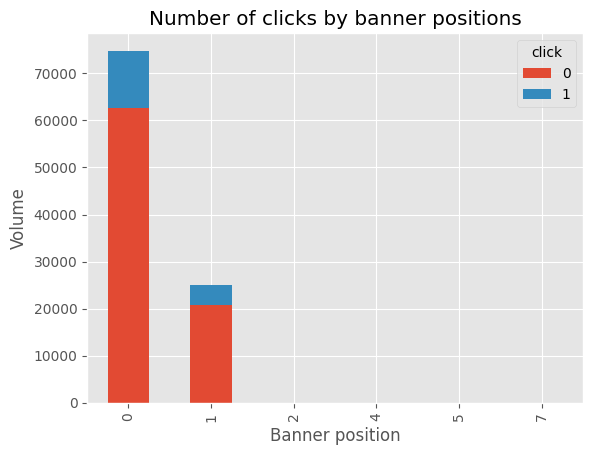

In [10]:
# banner position & click relation
# train_data['banner_pos'].unique()
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])
print('The number of clicks by different banner positions')
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')
plt.xlabel('Banner position')
plt.ylabel('Volume')
plt.title('Number of clicks by banner positions')

train_data.pivot_table(columns=['click'],index=['banner_pos'],values=['id'],aggfunc='count')

In [11]:
banner_df=train_data.pivot_table(columns=['click'],index=['banner_pos'],values=['id'],aggfunc='count')
banner_df.reset_index(inplace=True,drop=False)
banner_df.columns=['banner_pos','Non_click','click']
banner_df['total_impression']=banner_df['Non_click']+banner_df['click']
banner_df['click_pct']=banner_df['click']/banner_df['total_impression']
banner_df.sort_values(ascending=False,by='click_pct',inplace=False)
banner_df

,banner_pos,Non_click,click,total_impression,click_pct
0,0,62566,12209,74775,0.163276
1,1,20691,4424,25115,0.176150
2,2,26,4,30,0.133333
3,4,17,1,18,0.055556
4,5,35,3,38,0.078947
5,7,12,12,24,0.500000


##### Analysis on: device type

The number of clicks by different device types:


id       
click            0      1
device_type              
0             3325   1110
1            78250  15333
4             1543    187
5              229     23

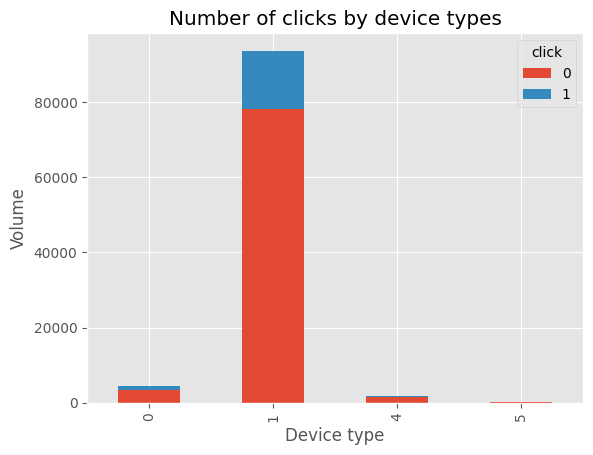

In [12]:
# Device type & click relation
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])
device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')
plt.xlabel('Device type')
plt.ylabel('Volume')
plt.title('Number of clicks by device types')

print('The number of clicks by different device types:')
train_data.pivot_table(columns=['click'],index=['device_type'],values=['id'],aggfunc='count')

In [13]:
device_df=train_data.pivot_table(columns=['click'],index=['device_type'],values=['id'],aggfunc='count')
device_df.reset_index(inplace=True,drop=False)
device_df.columns=['device_type','Non_click','click']
device_df['total_impression']=device_df['Non_click']+device_df['click']
device_df['click_pct']=device_df['click']/device_df['total_impression']
device_df.sort_values(ascending=False,by='click_pct',inplace=True)
print('Click percentages by different devices:')
device_df

Click percentages by different devices:


,device_type,Non_click,click,total_impression,click_pct
0,0,3325,1110,4435,0.250282
1,1,78250,15333,93583,0.163844
2,4,1543,187,1730,0.108092
3,5,229,23,252,0.091270


Clicks distribution over different devices:


,click
device_type,
0,0.066655
1,0.920735
4,0.011229
5,0.001381


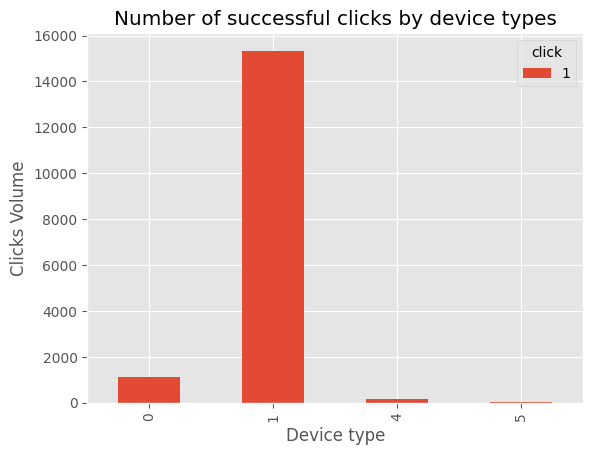

In [14]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')
plt.xlabel('Device type')
plt.ylabel('Clicks Volume')
plt.title('Number of successful clicks by device types')

print('Clicks distribution over different devices:')
train_data[train_data['click']==1][['click','device_type']].groupby('device_type').count()/(train_data[train_data['click']==1][['click']].count())

##### Analysis on: app category

In [15]:
# App category and click relation
app_features = ['app_id', 'app_domain', 'app_category']
app_df=train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)
app_df['total_clicks']=train_data[train_data['click']==1].shape[0]
app_df['click_dist']=app_df['click']/app_df['total_clicks']
print('Clicks distribution over differenct app category:')
app_df

Clicks distribution over differenct app category:


,click,total_clicks,click_dist
app_category,,,
07d7df22,11818,16653,0.709662
0f2161f8,3183,16653,0.191137
cef3e649,756,16653,0.045397
f95efa07,520,16653,0.031226
8ded1f7a,237,16653,0.014232
09481d60,79,16653,0.004744
d1327cf5,25,16653,0.001501
dc97ec06,11,16653,0.000661
75d80bbe,7,16653,0.000420


Text(0, 0.5, 'Percentage')

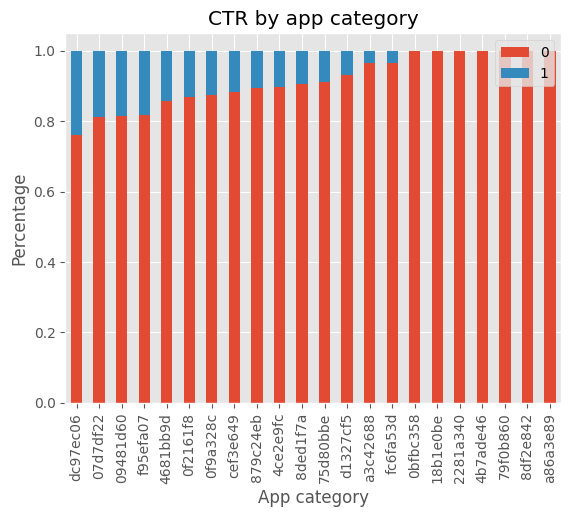

In [16]:
# Clicks behavior across different app categories
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()
train_app_category=train_app_category.div(train_app_category.sum(axis=1), axis=0)
train_app_category.columns=['0','1']
train_app_category.sort_values(ascending=False,by='1').plot(kind='bar', stacked=True, title="CTR by app category")
plt.xlabel('App category')
plt.ylabel('Percentage')

##### Analysis on: other anonymous features

In [17]:
# C1, C14-C21 features
features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C20', 'C21']
train_data[features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C20,C21
count,100000,100000,100000,100000,100000,100000,100000,100000
unique,7,741,7,8,205,4,157,41
top,1005,21767,320,50,1722,0,-1,157
freq,93188,3776,93074,93506,10705,50316,50908,16374


###### C1,C15,C16,C18

<Axes: title={'center': 'Click by C18'}, xlabel='C18'>

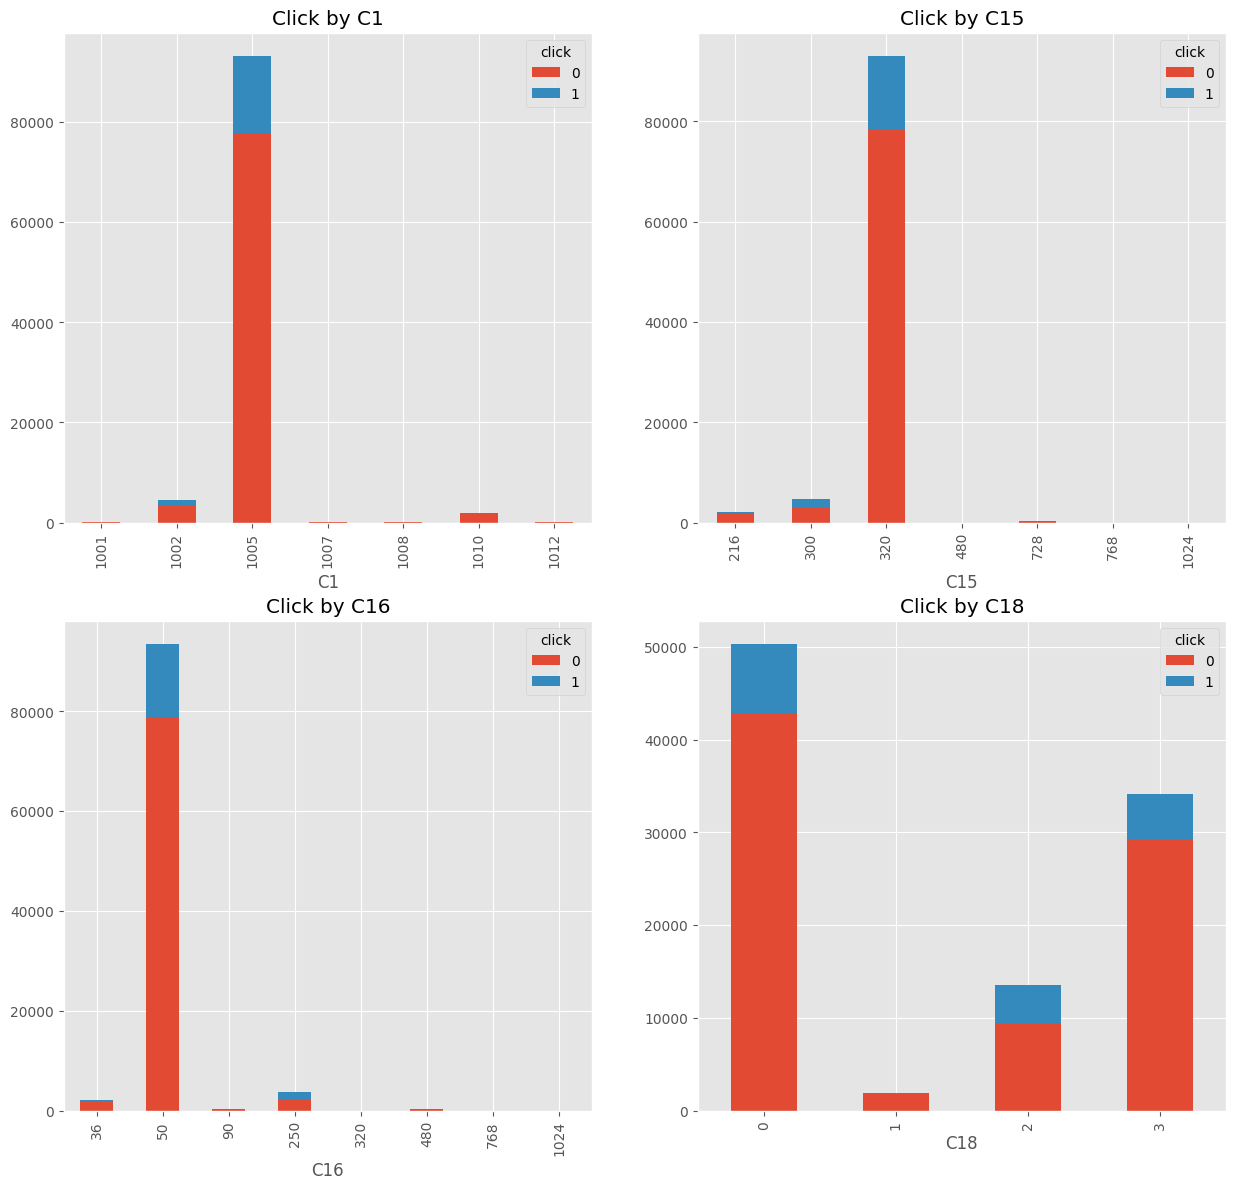

In [18]:
fig=plt.figure(figsize=(15,14))
ax=fig.add_subplot(2,2,1)
train_data.groupby(['C1', 'click']).size().unstack().plot(ax=ax,kind='bar', stacked=True, title='Click by C1')
ax=fig.add_subplot(2,2,2)
train_data.groupby(['C15', 'click']).size().unstack().plot(ax=ax,kind='bar', stacked=True, title='Click by C15')
ax=fig.add_subplot(2,2,3)
train_data.groupby(['C16', 'click']).size().unstack().plot(ax=ax,kind='bar', stacked=True, title='Click by C16')
ax=fig.add_subplot(2,2,4)
train_data.groupby(['C18', 'click']).size().unstack().plot(ax=ax,kind='bar', stacked=True, title='Click by C18')

###### C14

Text(0.5, 1.0, 'Non-Click distribution over C14')

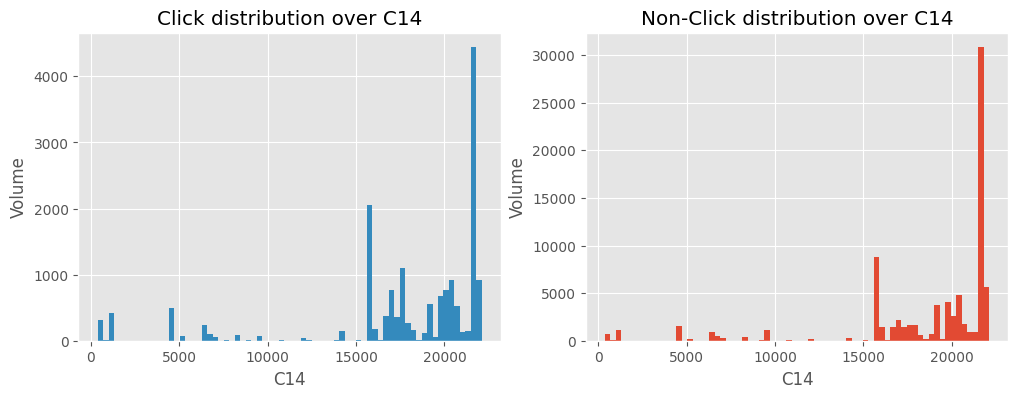

In [19]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax=plt.hist(train_data[train_data['click']==1]['C14'],bins=70,color='#348ABD')
plt.xlabel('C14')
plt.ylabel('Volume')
plt.title('Click distribution over C14')

ax=fig.add_subplot(1,2,2)
ax=plt.hist(train_data[train_data['click']==0]['C14'],bins=70,color='#E24A33')
plt.xlabel('C14')
plt.ylabel('Volume')
plt.title('Non-Click distribution over C14')

In [20]:
c14_df=train_data.pivot_table(columns=['click'],index=['C14'],values=['id'],aggfunc='count')
c14_df.reset_index(inplace=True,drop=False)
c14_df.columns=['C14','Non_click','click']
c14_df['total_impression']=c14_df['Non_click']+c14_df['click']
c14_df['CTR']=c14_df['click']/c14_df['total_impression']
c14_df['total_impression_dist']=c14_df['total_impression']*1.0/c14_df['total_impression'].sum()
#c14_df.sort_values(ascending=False,by='total_impression',inplace=True)
print('Top C14 Categories with hig impression & CTR:')
c14_df[(c14_df['total_impression']>500) & (c14_df['CTR']>0.25)].sort_values(ascending=False,by='CTR')

Top C14 Categories with hig impression & CTR:


,C14,Non_click,click,total_impression,CTR,total_impression_dist
226,17753,310.0,276.0,586.0,0.470990,0.005933
219,17614,317.0,274.0,591.0,0.463621,0.005983
221,17654,313.0,210.0,523.0,0.401530,0.005295
220,17653,305.0,198.0,503.0,0.393638,0.005092
282,19665,372.0,227.0,599.0,0.378965,0.006064
12,1037,389.0,177.0,566.0,0.312721,0.005730
396,20633,511.0,195.0,706.0,0.276204,0.007147
193,16920,886.0,334.0,1220.0,0.273770,0.012351
397,20634,440.0,155.0,595.0,0.260504,0.006024
47,6563,449.0,150.0,599.0,0.250417,0.006064


###### C17

Text(0.5, 1.0, 'Non-Click distribution over C17')

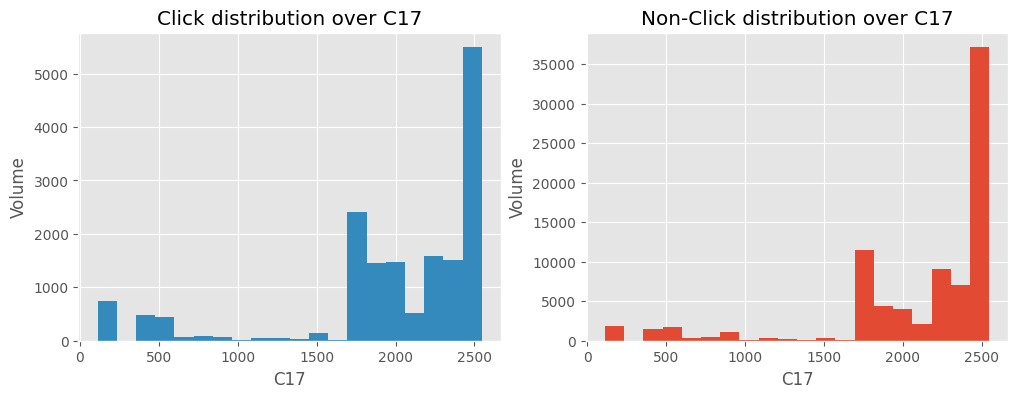

In [21]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax=plt.hist(train_data[train_data['click']==1]['C17'],bins=20,color='#348ABD')
plt.xlabel('C17')
plt.ylabel('Volume')
plt.title('Click distribution over C17')

ax=fig.add_subplot(1,2,2)
ax=plt.hist(train_data[train_data['click']==0]['C17'],bins=20,color='#E24A33')
plt.xlabel('C17')
plt.ylabel('Volume')
plt.title('Non-Click distribution over C17')

###### C20

Click distribution for C20=-1:


,C20
click,
0,41588
1,9320


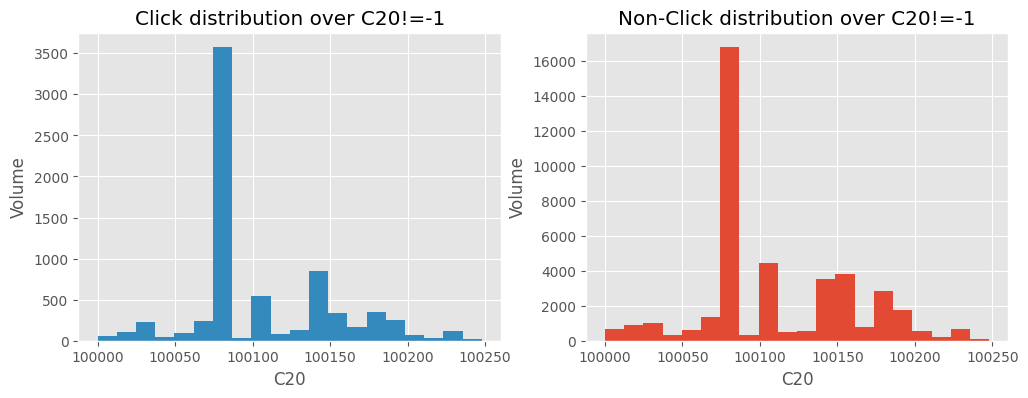

In [22]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax=plt.hist(train_data[(train_data['click']==1) & (train_data['C20']!=-1)]['C20'],bins=20,color='#348ABD')
plt.xlabel('C20')
plt.ylabel('Volume')
plt.title('Click distribution over C20!=-1')

ax=fig.add_subplot(1,2,2)
ax=plt.hist(train_data[(train_data['click']==0) & (train_data['C20']!=-1)]['C20'],bins=20,color='#E24A33')
plt.xlabel('C20')
plt.ylabel('Volume')
plt.title('Non-Click distribution over C20!=-1')

print('Click distribution for C20=-1:')
train_data[train_data['C20']==-1][['click','C20']].groupby('click').count()

###### C21

Text(0.5, 1.0, 'Non-Click distribution over C21')

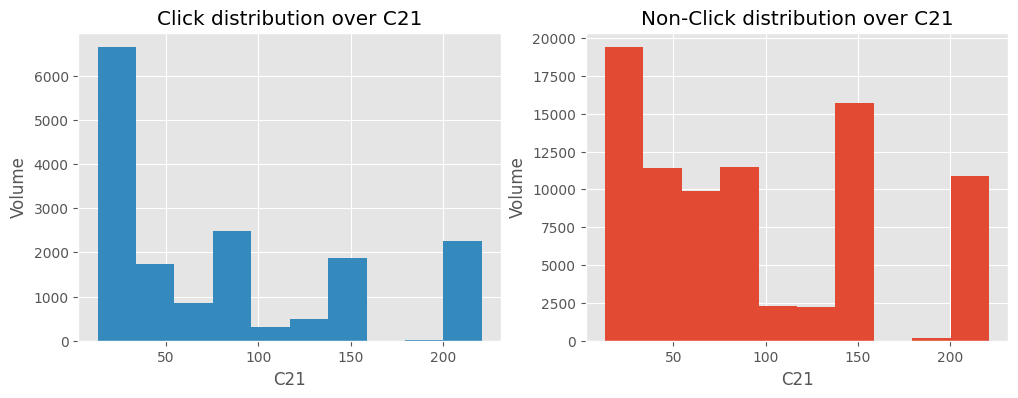

In [23]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax=plt.hist(train_data[train_data['click']==1]['C21'],bins=10,color='#348ABD')
plt.xlabel('C21')
plt.ylabel('Volume')
plt.title('Click distribution over C21')

ax=fig.add_subplot(1,2,2)
ax=plt.hist(train_data[train_data['click']==0]['C21'],bins=10,color='#E24A33')
plt.xlabel('C21')
plt.ylabel('Volume')
plt.title('Non-Click distribution over C21')

## **Data Pre-processing**

In [5]:
saving_train_data=train_data.copy(deep=True)

In [6]:
pd.set_option('display.max_columns', None)
train_data.head(2)

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,2014-10-21 01:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,2014-10-21 03:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79


##### Create new features

In [7]:
train_data['hour_inday']=train_data['hour'].dt.hour

In [8]:
def C14_classify(x):
  if x<=2500: return 1
  elif x<=7500: return 2
  elif x<=16920: return 3 #25 percentile
  elif x<=20352: return 4 #50 percentile
  elif x<=21759: return 5 #75 percentile
  else: return 6
train_data['C14_class']=train_data['C14'].apply(lambda x: C14_classify(x))

In [9]:
def C17_classify(x):
  if x<=300: return 1
  elif x<=600: return 2
  elif x<=1863: return 3 #25 percentile
  elif x<=2333: return 4 #50 percentile
  elif x<=2502: return 5 #75 percentile
  else: return 6
train_data['C17_class']=train_data['C17'].apply(lambda x: C17_classify(x))

In [10]:
def C20_classify(x):
  if x==-1: return 1
  elif x<=100077: return 2 #25 percentile
  elif x<=100084: return 3 #50 percentile
  elif x<=100148: return 4 #75 percentile
  else: return 5
train_data['C20_class']=train_data['C20'].apply(lambda x: C20_classify(x))

In [11]:
def C21_classify(x):
  if x<=33: return 1 #25 percentile
  elif x<=79: return 2 #50 percentile
  elif x<=157: return 3 #75 percentile
  else: return 4
train_data['C21_class']=train_data['C21'].apply(lambda x: C21_classify(x))

In [12]:
# select features
model_features = ['banner_pos', 'site_category','app_category','device_type','device_conn_type',
                  'hour_inday','C1','C15','C16','C18','C14_class', 'C17_class', 'C20_class','C21_class']
model_target = 'click'
train_model = train_data[model_features+[model_target]].sample(frac=0.2,random_state=42)
#.sample()--used to select randomly rows or columns from a DataFrame

In [32]:
print('Before transformation, there are total {} features.'.format(train_model.shape[1]))
train_model.shape

Before transformation, there are total 15 features.


(20000, 15)

##### Transform categorical feature to numerical feature

In [ ]:
# categorical feature encoding
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                    columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [ ]:
train_model = one_hot_features(train_model,
                               ['banner_pos', 'site_category','app_category','device_type','device_conn_type',
                                'hour_inday','C1','C15','C16','C18','C14_class', 'C17_class',
                                'C20_class','C21_class']
                                #['site_category','app_category','banner_pos']
                               )
train_model.head(2)

,click,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_4,banner_pos_5,banner_pos_7,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,site_category_50e219e0,site_category_70fb0e29,site_category_72722551,site_category_75fa27f6,site_category_76b2941d,site_category_a818d37a,site_category_bcf865d9,site_category_c0dd3be3,site_category_dedf689d,site_category_e787de0e,site_category_f028772b,site_category_f66779e6,app_category_07d7df22,app_category_09481d60,app_category_0bfbc358,app_category_0f2161f8,app_category_0f9a328c,app_category_2281a340,app_category_4681bb9d,app_category_4ce2e9fc,app_category_75d80bbe,app_category_79f0b860,app_category_879c24eb,app_category_8ded1f7a,app_category_8df2e842,app_category_a3c42688,app_category_cef3e649,app_category_d1327cf5,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,device_type_0,device_type_1,device_type_4,device_type_5,device_conn_type_0,device_conn_type_2,device_conn_type_3,device_conn_type_5,hour_inday_0,hour_inday_1,hour_inday_2,hour_inday_3,hour_inday_4,hour_inday_5,hour_inday_6,hour_inday_7,hour_inday_8,hour_inday_9,hour_inday_10,hour_inday_11,hour_inday_12,hour_inday_13,hour_inday_14,hour_inday_15,hour_inday_16,hour_inday_17,hour_inday_18,hour_inday_19,hour_inday_20,hour_inday_21,hour_inday_22,hour_inday_23,C1_1001,C1_1002,C1_1005,C1_1007,C1_1008,C1_1010,C1_1012,C15_216,C15_300,C15_320,C15_728,C15_768,C16_36,C16_50,C16_90,C16_250,C16_480,C16_1024,C18_0,C18_1,C18_2,C18_3,C14_class_1,C14_class_2,C14_class_3,C14_class_4,C14_class_5,C14_class_6,C17_class_1,C17_class_2,C17_class_3,C17_class_4,C17_class_5,C17_class_6,C20_class_1,C20_class_2,C20_class_3,C20_class_4,C20_class_5,C21_class_1,C21_class_2,C21_class_3,C21_class_4
75721,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
80184,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [ ]:
print('After transformation, there are total {} features.'.format(train_model.shape[1]))
train_model.shape

After transformation, there are total 118 features.


(20000, 118)

In [ ]:
# Extracting all columns from the train model except the target mask column
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

## Model Training

##### Train & Test Split

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( train_model[model_features].values,
                                                     train_model[model_target].values,
                                                     test_size=0.3,
                                                     random_state=42)

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score,roc_auc_score

##### Logistic Regression Model

In [ ]:
# F1 score used as a performance metric
num_splits = 3
c_values = np.logspace(-2, 0, 5)

# stratified k-fold
# which is a variant of k-fold cross-validation specifically designed
# for classification problems where the target variable has imbalanced classes
stratified_k_fold = StratifiedKFold(n_splits=num_splits)
scores = np.zeros(5)
nr_params = np.zeros(5)


#c: regularization strength
for train_data, valid_data in stratified_k_fold.split(x_train,y_train):
    for i, c in enumerate(np.logspace(-2, 0, 5)):
        lr_classify = LogisticRegression(penalty='l2',
                                         class_weight='balanced',
                                         C = c,
                                         max_iter=1000,
                                         random_state=42)
        lr_classify.fit(x_train[train_data],y_train[train_data])

        #validation_Set evaluation
        y_prediction = lr_classify.predict(x_train[valid_data])
        score_f1 = f1_score(y_train[valid_data],y_prediction, average='weighted' )

        scores[i] += score_f1 / num_splits
        #print(scores[i])

        ### spot the selected parameters ##
        model_selected = SelectFromModel(lr_classify, prefit=True)
        nr_params[i] += np.sum(model_selected.get_support()) / num_splits

Text(0.5, 1.0, 'Hyperparameter Tuning for Logistic Regression: regression strength')

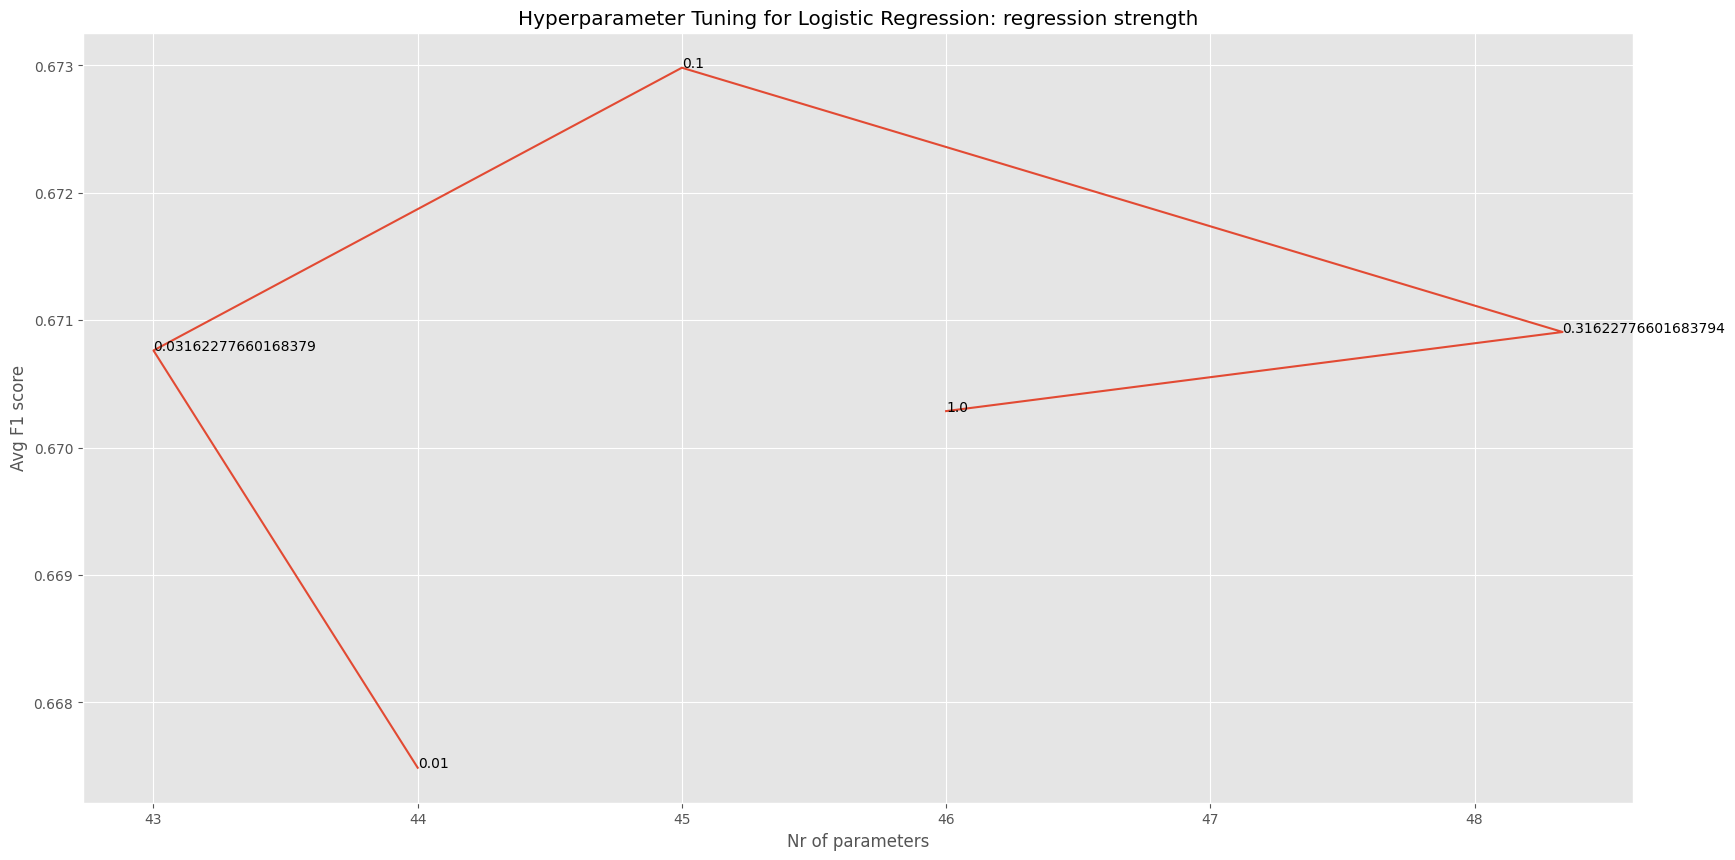

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(nr_params, scores)

for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Nr of parameters")
plt.ylabel("Avg F1 score")
plt.title('Hyperparameter Tuning for Logistic Regression: regression strength')

Note: Base on the above results, regularization term c=0.1 seems the best hyperparameter for this model, resulting an average F1 score as 0.673

##### XGBoost Model

In [32]:
# XGBoost classifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
#Split validation set:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    stratify=y_train,
    test_size=0.1)


xgb_clf = XGBClassifier(eval_metric="logloss")
#Note: “LogLoss\=−N1​i\=1∑N​\[yi​⋅log(pi​)+(1−yi​)⋅log(1−pi​)\]” commonly used for binary classification

xgb_clf.fit(x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_clf.predict(x_test)
predictions = [round(value) for value in y_pred]
print(classification_report(y_test,predictions))
print('Overall F1 Score is: ',f1_score(y_test,predictions, average='weighted' ))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      4982
           1       0.44      0.08      0.14      1018

    accuracy                           0.83      6000
   macro avg       0.64      0.53      0.52      6000
weighted avg       0.77      0.83      0.77      6000

Overall F1 Score is:  0.7740346072271825


Note:\
**Class 0 (majority class)**:

Precision = 0.83: 83% of the time when the model predicts 0, it's correct.

Recall = 0.96: The model correctly identifies 96% of all actual 0s.

F1 = 0.89: Good balance of precision and recall.

**Class 1 (minority class)**:

Precision = 0.37: Only 37% of predictions for class 1 are correct.

Recall = 0.11: The model finds only 11% of actual class 1s.

F1 = 0.16: Very poor performance on class 1.

##### Parametertuning for XGBoost Model

######Approach 1: Grid Search

In [ ]:
# Define helper function
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [ ]:
# Choose the number of trees
parameters = {
    'n_estimators' : [100], #[80, 100, 120], #Number of boosting rounds / trees
    'max_depth' : [4, 6, 8], #Maximum depth of each tree
    'learning_rate': [0.1,0.15,0.25,0.3], #Step size shrinkage (smaller = slower but better)
    'reg_lambda':[4,6,8] #L2 regularization on weights
}

#Setting the model tuning goal to be ROC_AUC score:
Grid_xgb = GridSearchCV(xgb_clf, parameters, scoring='roc_auc', cv=5)
Grid_xgb.fit(x_train, y_train)
#Grid_xgb = GridSearchCV(xgb_clf, parameters, scoring='f1', cv=5)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.15, 0.25, 0.3],
                         'max_depth': [4, 6, 8], 'n_estimators': [100],
                         'reg_lambda': [4, 6, 8]},
             scoring='roc_auc')

In [ ]:
# best number of parameters
print_grid_search_metrics(Grid_xgb)

Best score: 0.6866471584409467
Best parameters set:
learning_rate:0.1
max_depth:6
n_estimators:100
reg_lambda:8


In [ ]:
tuning_tb=pd.concat([pd.DataFrame(Grid_xgb.cv_results_['params']),pd.DataFrame(Grid_xgb.cv_results_['mean_test_score'],columns=['auc_score'])],axis=1)

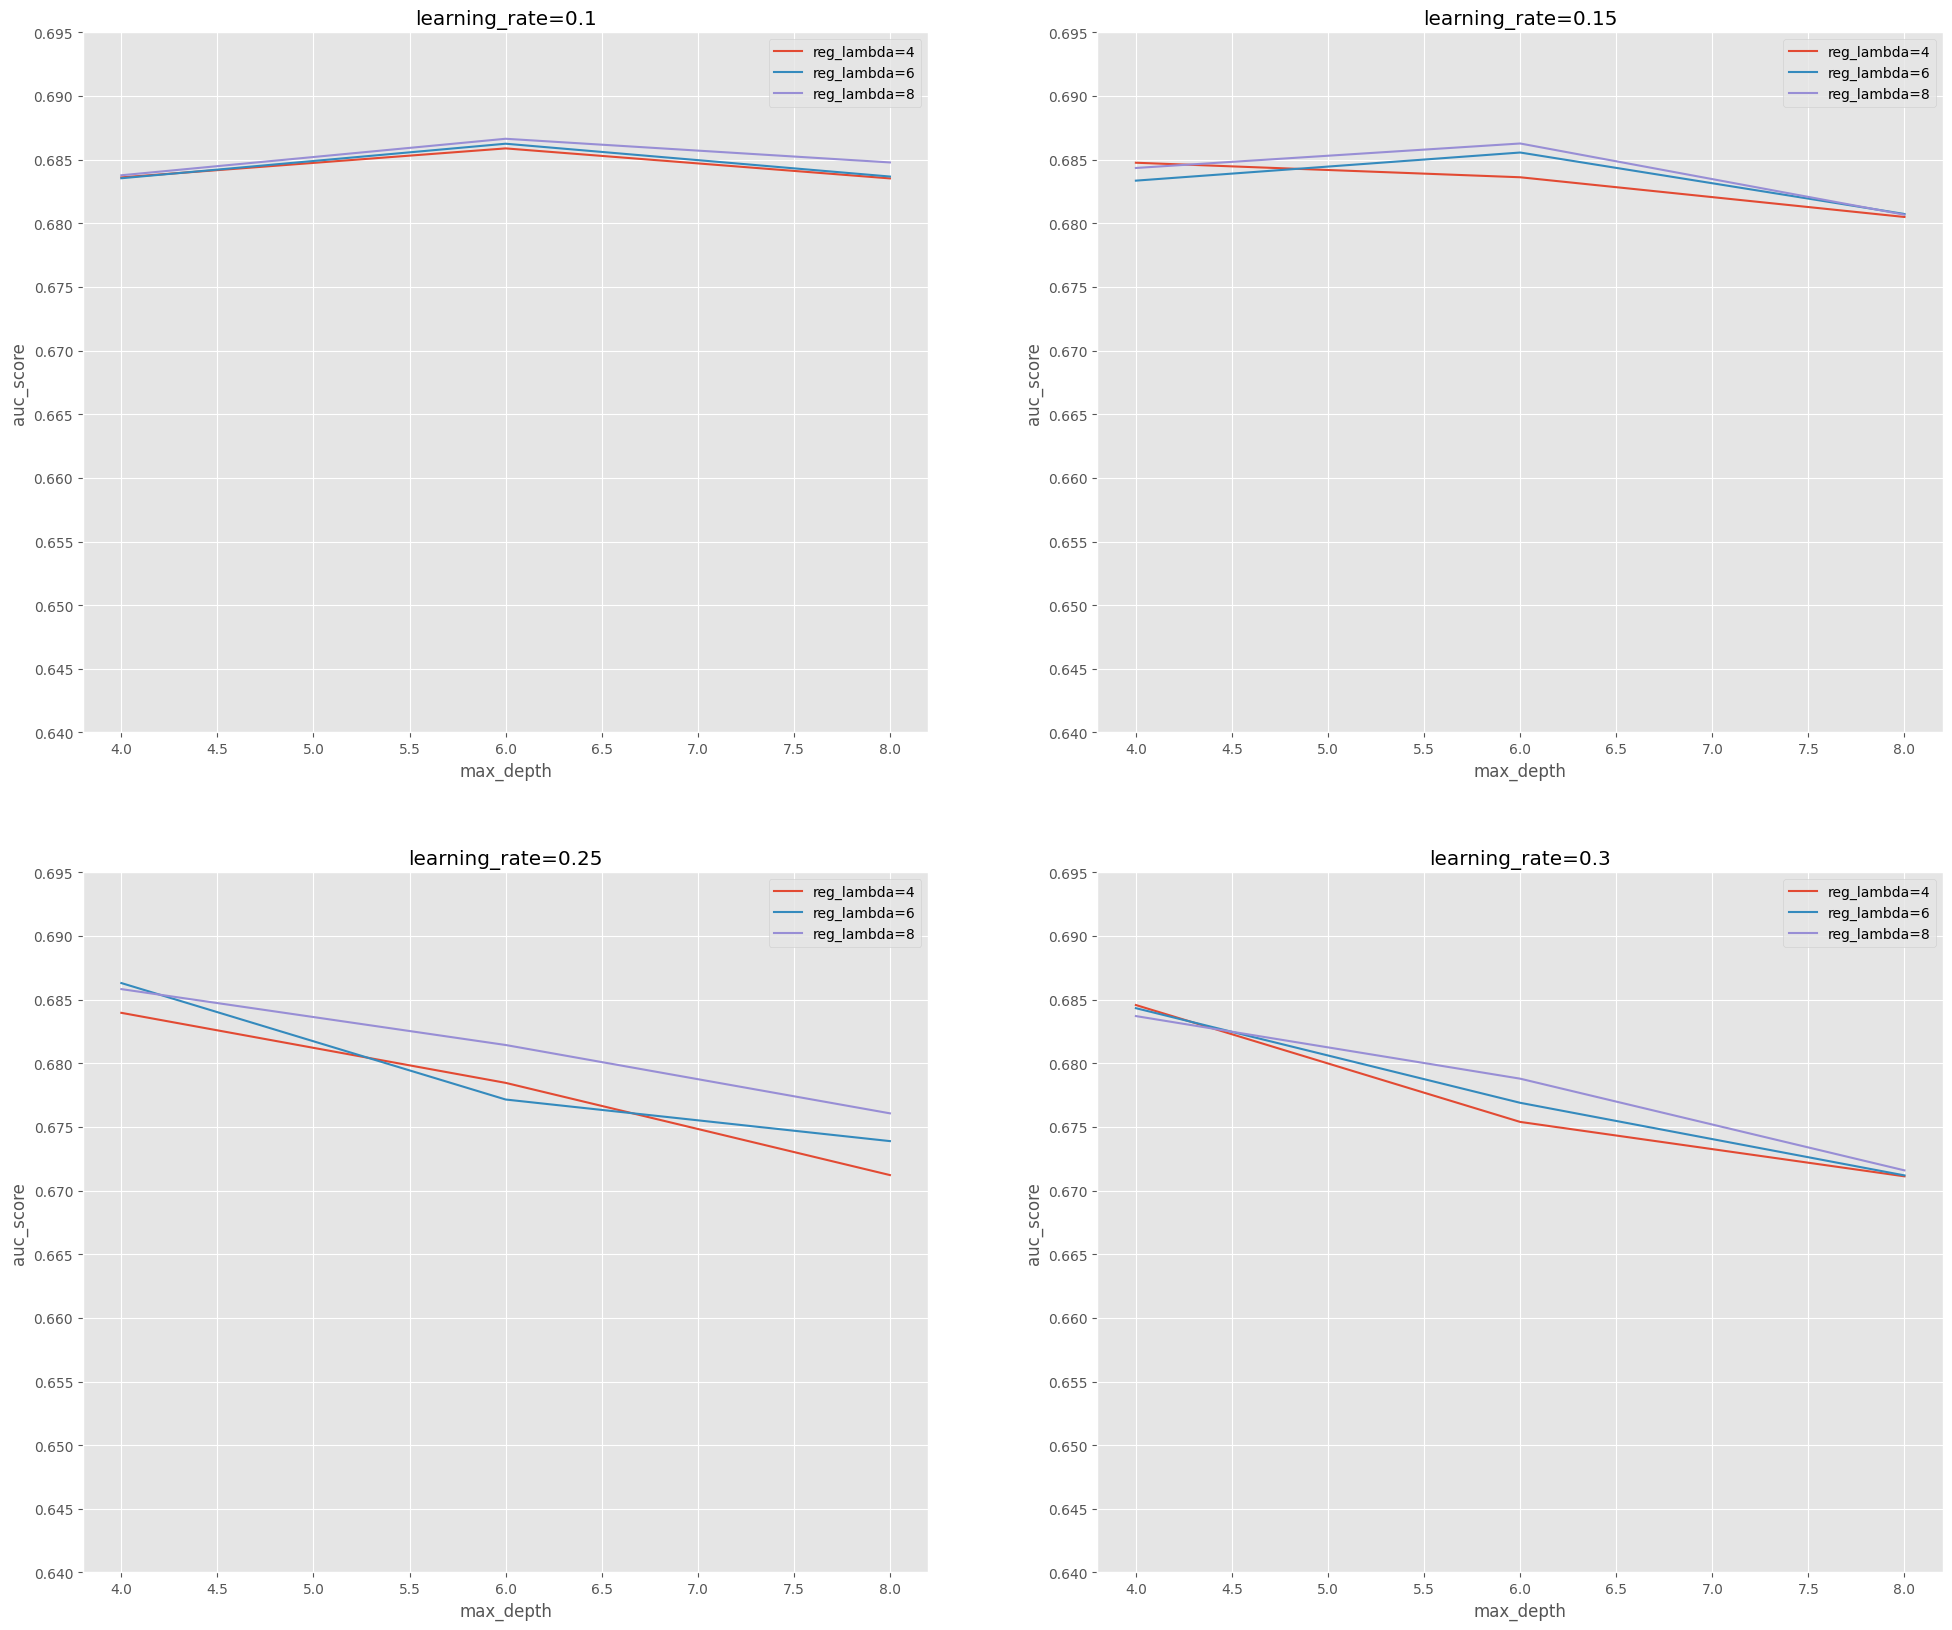

In [ ]:
fig=plt.figure(figsize=(24,20))
for i,lr in enumerate([0.1,0.15,0.25,0.3]): #learning_rate range
  ax=fig.add_subplot(2,2,i+1)
  for reg_lambda in [4,6,8]: #regularization term
    dt_p=tuning_tb[(tuning_tb['learning_rate']==lr)&(tuning_tb['reg_lambda']==reg_lambda)]
    plt.plot(dt_p['max_depth'],dt_p['auc_score'],label='reg_lambda='+str(reg_lambda))
  plt.xlabel('max_depth')
  plt.ylabel('auc_score')
  plt.title('learning_rate='+str(lr))
  plt.yticks(np.arange(0.64,0.70,0.005))
  plt.legend()

In [ ]:
# best model
best_xgb_model_gs = Grid_xgb.best_estimator_

In [ ]:
y_pred_best_xgb = best_xgb_model_gs.predict(x_test)
predictions_best_xgb = [round(value) for value in y_pred_best_xgb]
print(classification_report(y_test,predictions_best_xgb))
print('Overall F1 Score is: ',f1_score(y_test,predictions_best_xgb, average='weighted' ))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4982
           1       0.53      0.06      0.10      1018

    accuracy                           0.83      6000
   macro avg       0.68      0.52      0.50      6000
weighted avg       0.79      0.83      0.77      6000

Overall F1 Score is:  0.7703338544061303


###### Approach 2: Bayesian Optimization

In [ ]:
pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

Define the parameter search space
param_space = {
   'n_estimators' : (100),#80,100
   'max_depth' : (4, 8),}

In [ ]:
#Define the parameter search space
param_space={
    'n_estimators' : [100], #[80, 100, 120], #Number of boosting rounds / trees
    'max_depth' : [4, 6, 8], #Maximum depth of each tree
    'learning_rate': [0.1,0.15,0.2], #Step size shrinkage (smaller = slower but better)
    'reg_lambda':[4,6,8] #L2 regularization on weights
}

In [ ]:
# Initialize Bayesian Optimization

#opt = BayesSearchCV(estimator=xgb_clf, search_spaces=param_space, scoring='f1', n_iter=32, cv=5, random_state=10)
opt = BayesSearchCV(estimator=xgb_clf,
                    search_spaces=param_space,
                    scoring='roc_auc',
                    n_iter=32,
                    cv=5,
                    random_state=42)

#xgb_clf = XGBClassifier(eval_metric="logloss")

# Fit the model
opt.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.float64(0.15), np.int64(4), np.int64(100), np.int64(4)] before, using random point [0.1, 6, 100, 6]

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.float64(0.2), np.int64(8), np.int64(100), np.int64(4)] before, using random point [0.1, 8, 100, 6]

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.float64(0.1), np.int64(8), np.int64(100), np.int64(4)] before, using random point [0.15, 8, 100, 8]

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.float64(0.1), np.int64(6), np.int64(100), np.int64(8)] before, using random point [0.2, 8, 100, 6]



BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=32, random_state=42, scoring='roc_auc',
              search_spaces={'learning_rate': [0.1, 0.15, 0.2],
                             'max_depth': [4, 6, 8], 'n_estimators': [100],
                             'reg_lambda': [4, 6, 8]})

In [ ]:
# best number of parameters
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)

Best parameters found:  OrderedDict([('learning_rate', 0.1), ('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 8)])
Best cross-validation score:  0.6866471584409467


In [ ]:
# best model
best_xgb_model_by = opt.best_estimator_

In [ ]:
y_pred_best_xgb_by = best_xgb_model_by.predict(x_test)
predictions_best_xgb_by = [round(value) for value in y_pred_best_xgb_by]
print(classification_report(y_test,predictions_best_xgb_by))
print('Overall F1 Score is: ',f1_score(y_test,predictions_best_xgb_by, average='weighted'))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4982
           1       0.53      0.06      0.10      1018

    accuracy                           0.83      6000
   macro avg       0.68      0.52      0.50      6000
weighted avg       0.79      0.83      0.77      6000

Overall F1 Score is:  0.7703338544061303


## Wide and Deep Neural Network

##### Model Environment Setup

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm # progress bar utility, used in loops to visually track progress
import gc #allows you to manually manage memory,especially useful in memory-intensive tasks

In [14]:
device = 'cpu'
use_cuda = True
#Need to allow T4 GPU in Colab notebook
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda'
print('Current device to use is: ',device)

cuda ready...
Current device to use is:  cuda


##### Feature Engineering

In [15]:
#Drop unuseful information: ID and
df_wd=train_data.iloc[:,2:]

In [16]:
df_wd['hr-app_category'] = df_wd['hour_inday'].astype(str) + df_wd['app_category']
df_wd['hr-site_category'] = df_wd['hour_inday'].astype(str) + df_wd['site_category']
df_wd['hr-device_type'] = df_wd['hour_inday'].astype(str) + df_wd['device_type'].astype(str)
df_wd['banner_pos-device_type'] = df_wd['banner_pos'].astype(str) + df_wd['device_type'].astype(str)
df_wd['device_type-app_category'] = df_wd['device_type'].astype(str) + df_wd['app_category']
df_wd['device_type-site_category'] = df_wd['device_type'].astype(str) + df_wd['site_category']
df_wd['hour']=df_wd['hour'].dt.year.astype(str) + df_wd['hour'].dt.month.astype(str) + df_wd['hour'].dt.day.astype(str) + df_wd['hour'].dt.hour.astype(str)


In [17]:
#Showing description of all current columns:
df_wd.astype('object').describe(include='all')

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_inday,C14_class,C17_class,C20_class,C21_class,hr-app_category,hr-site_category,hr-device_type,banner_pos-device_type,device_type-app_category,device_type-site_category
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,2,53,7,6,1322,1150,19,1301,94,22,17258,73440,3120,4,4,741,7,8,205,4,44,157,41,24,6,6,5,4,325,299,96,10,39,22
top,0,201410229,1005,0,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,a99f214a,6b9769f2,8a4875bd,1,0,21767,320,50,1722,0,35,-1,157,9,5,4,1,2,1007d7df22,950e219e0,91,01,107d7df22,150e219e0
freq,83347,4457,93188,74775,38208,39518,41767,61792,65408,62800,81436,548,6204,93583,89039,3776,93074,93506,10705,50316,48872,50908,16374,6708,25090,27639,50908,35264,3747,3408,6372,70340,58365,35350


In [18]:
#Drop very unique and specific columns, not useful for model training
df_wd=df_wd.drop(columns=(['device_ip','device_id']))

##### Encode Categorical Features & Handle Missing Values

In [19]:
#Seperate object type feature and int type feature
obj_features = list(df_wd.select_dtypes(['object']).columns)
int_features = list(df_wd.select_dtypes(['int64']).columns)
int_features.remove('click')

#Fill missing values for different type of feature
df_wd[obj_features] = df_wd[obj_features].fillna('-1', )
df_wd[int_features] = df_wd[int_features].fillna(0, )

for feat in obj_features:
    lbe = LabelEncoder() #convert categorical (textual) labels into numeric values
    df_wd[feat] = lbe.fit_transform(df_wd[feat])

In [20]:
#Identify features with less than 100 unique values,and transform it using one_hot_encoding
CTR = df_wd.copy(deep=True)
CTR=CTR.drop(columns=['hour'])

sparse_features = CTR.loc[:, CTR.nunique() <= 100].columns.tolist()
sparse_features.remove('click')

for feat in sparse_features:
  CTR_temp = pd.get_dummies(CTR[feat], prefix=[feat])
  CTR = CTR.drop(feat, axis=1)
  CTR = pd.concat([CTR, CTR_temp], axis=1)

In [21]:
print('Before transformation, the total number of feature is: ',df_wd.shape[1])
print('After transformation, the total number of feature is: ', CTR.shape[1])

Before transformation, the total number of feature is:  32
After transformation, the total number of feature is:  482


##### Train & Test Split

In [22]:
# generate input data for model
train, test = train_test_split(CTR, test_size=0.2, random_state=42)

In [23]:
CTR.astype('object').describe(include='all')

,click,site_id,site_domain,app_id,device_model,C14,C17,C20,hr-app_category,hr-site_category,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['app_domain']_0,['app_domain']_1,['app_domain']_2,['app_domain']_3,['app_domain']_4,['app_domain']_5,['app_domain']_6,['app_domain']_7,['app_domain']_8,['app_domain']_9,['app_domain']_10,['app_domain']_11,['app_domain']_12,['app_domain']_13,['app_domain']_14,['app_domain']_15,['app_domain']_16,['app_domain']_17,['app_domain']_18,['app_domain']_19,['app_domain']_20,['app_domain']_21,['app_domain']_22,['app_domain']_23,['app_domain']_24,['app_domain']_25,['app_domain']_26,['app_domain']_27,['app_domain']_28,['app_domain']_29,['app_domain']_30,['app_domain']_31,['app_domain']_32,['app_domain']_33,['app_domain']_34,['app_domain']_35,['app_domain']_36,['app_domain']_37,['app_domain']_38,['app_domain']_39,['app_domain']_40,['app_domain']_41,['app_domain']_42,['app_domain']_43,['app_domain']_44,['app_domain']_45,['app_domain']_46,['app_domain']_47,['app_domain']_48,['app_domain']_49,['app_domain']_50,['app_domain']_51,['app_domain']_52,['app_domain']_53,['app_domain']_54,['app_domain']_55,['app_domain']_56,['app_domain']_57,['app_domain']_58,['app_domain']_59,['app_domain']_60,['app_domain']_61,['app_domain']_62,['app_domain']_63,['app_domain']_64,['app_domain']_65,['app_domain']_66,['app_domain']_67,['app_domain']_68,['app_domain']_69,['app_domain']_70,['app_domain']_71,['app_domain']_72,['app_domain']_73,['app_domain']_74,['app_domain']_75,['app_domain']_76,['app_domain']_77,['app_domain']_78,['app_domain']_79,['app_domain']_80,['app_domain']_81,['app_domain']_82,['app_domain']_83,['app_domain']_84,['app_domain']_85,['app_domain']_86,['app_domain']_87,['app_domain']_88,['app_domain']_89,['app_domain']_90,['app_domain']_91,['app_domain']_92,['app_domain']_93,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_39,['C19']_41,['C19']_43,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_291,['C19']_297,['C19']_299,['C19']_303,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_811,['C19']_813,['C19']_943,['C19']_1063,['C19']_1071,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1711,['C19']_1835,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,

In [24]:
print('The total number of dummy variables are: ')
len(CTR.loc[:, CTR.nunique() ==2].columns.tolist())-1 #Get all dummy variables(minus 'click')

The total number of dummy variables are: 


472

##### Model Designing

In [25]:
w_feature=CTR.loc[:, CTR.nunique() ==2].columns.tolist()
w_feature.remove('click')

In [26]:
#Each string encodes:
#The feature name--The vocabulary size (number of unique categories)--The embedding dimension
EMBEDDING_INPUTS = [
           'device_modelSEP3120SEP256',
           'app_idSEP1301SEP256',
           'site_idSEP1322SEP256',
           'site_domainSEP1150SEP256',
           #'C14SEP741SEP256',
           #'C17SEP205SEP256',
           #'C20SEP157SEFP256'
           #'app_domainSEP143SEP128',
          ]

EMBEDDING_INPUTS1 = [
           'device_model',
           'app_id',
           'site_id',
           'site_domain',
           #'C14',
           #'C17',
           #'C20',
           #'app_domain',
          ]

WIDE_DIM = 472 #423

In [83]:
# build model

class Model(nn.Module):
    def __init__(self, wide_dim, embedding_inputs, hidden_layers, dropout_p=0.7):
        super().__init__()
        self.wide_dim = wide_dim
        self.embedding_inputs = embedding_inputs
        self.deep_feature_dim = 0
        self.hidden_layers = hidden_layers

        # For each deep feature, create an embedding layer to convert them to embeddings
        for embedding_input in self.embedding_inputs:
            col_name, vocab_size, embed_dim = embedding_input.split('SEP')
            #print(col_name, vocab_size, embed_dim)
            setattr(self, col_name+'_emb_layer', nn.Embedding(int(vocab_size), int(embed_dim)))
            #Note: nn.Embedding(input_dimension, embedding_dimension), convert each device model ID (an int from 0 to 3119) into a 256-dimensional vector.
            #Note: setattr()-useful when creating many embedding layers in a loop; equal to self.device_model_emb_layer = nn.Embedding(4380, 256)
            self.deep_feature_dim += int(embed_dim)

        # A series of hidden layers that take the embeddings as input
        self.linear_layer_1 = nn.Linear(self.deep_feature_dim, self.hidden_layers[0])
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        #Note: Batch normalization, make sure each feature is normally distributed.(mean=0, variance=1)
        for i, hidden_layer in enumerate(self.hidden_layers[1:]):
            setattr(self, f'linear_layer_{i+2}', nn.Linear(self.hidden_layers[i], hidden_layer))

        self.dropout = nn.Dropout(p=0.5)
        #Note: During training, 70% of the neurons passed into this layer will be randomly set to zero
        #      at each forward pass. Commonly used values are 0.2~0.5

        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim+self.hidden_layers[-1], 1)


    def forward(self, X_w, X_d):
        embeddings = [getattr(self, col_name+'_emb_layer')(X_d[:, i].long()) #Access corresponding embedding layer self.device_model_emb_layer & column X_d[:, i], converts it to long (required for embeddings).
                      for i, embedding_input in enumerate(self.embedding_inputs)
                      for col_name in embedding_input.split('SEP')
                      if not col_name.isdigit() #Get embedding column name: eg."device_model"
                     ]

        deep_out = torch.cat(embeddings, dim=-1)
        # concatenate the embeddings of all deep features
        # concatenates all the embedding outputs along the last dimension

        for i, _ in enumerate(self.hidden_layers):
            deep_out = F.relu(getattr(self, f'linear_layer_{i+1}')(deep_out))

        X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        out = self.fc(fc_input)

        return out

##### Model Training

In [84]:
model = Model(wide_dim=WIDE_DIM,
              embedding_inputs=EMBEDDING_INPUTS,
              hidden_layers=[256,128,64], #[512, 256, 128],
              dropout_p=0.7)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
#Note: It’s commonly used in binary classification tasks (e.g., predicting CTR),
#      where the model outputs a single logit (real number), and want to predict either 0 or 1.
#      loss function in PyTorch that combines: Sigmoid activation & Binary Cross-Entropy (BCE) loss

scaler=torch.amp.GradScaler()
#scaler = torch.cuda.amp.GradScaler()
#Note: enable automatic mixed precision training in PyTorch, improving training speed and
#      memory efficiency on GPUs, while maintaining accuracy

best_val_loss = float('inf')
train_losses = []
test_losses = []

# training
X_w_train = torch.tensor(train.iloc[:][w_feature].values.astype(np.float32)) #train.iloc[:][w_feature].values.shape=(80000,472)
X_w_train = X_w_train.squeeze().to(device)
#Note: .squeeze()--Removes dimensions of size 1. (e.g., [80000, 1] → [80000])
X_d_train = torch.tensor(train.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_train = X_d_train.squeeze().to(device)
label_train = torch.tensor(train['click'].values.astype(np.float32)).to(device)
label_train = label_train.squeeze().unsqueeze(1).to(device)
#Note: .unsqueeze(1)--Adds a new dimension at position 1 (i.e., makes it a column vector).
#      Final shape: [80000, 1], required by binary classification models like BCEWithLogitsLoss.
#--------------------------------------------------------------------------------------------------

# testing
X_w_test = torch.tensor(test.iloc[:][w_feature].values.astype(np.float32))
X_w_test = X_w_test.squeeze().to(device)
X_d_test = torch.tensor(test.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_test = X_d_test.squeeze().to(device)
label_test = torch.tensor(test['click'].values.astype(np.float32)).to(device)
label_test = label_test.squeeze().unsqueeze(1).to(device)

for epoch in range(100):
    y_pred_train = model(X_w_train,X_d_train)
    loss_train = loss_fn(y_pred_train, label_train)

    optimizer.zero_grad()
    scaler.scale(loss_train).backward()
    scaler.step(optimizer)
    scaler.update()

    y_pred_test = model(X_w_test,X_d_test)
    loss_test = loss_fn(y_pred_test, label_test)
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

    if epoch%10==0:
      print(f'=============== Epoch {epoch} ===============')
      print('epoch:', epoch, 'Training Loss:', loss_train.item())
      print('epoch:', epoch, 'testing Loss:', loss_test.item())

    if test_losses[-1] < best_val_loss:
        best_val_loss = test_losses[-1]
        # print('Best model saved.\n')
        # torch.save(model.state_dict(), './saved_model.pt')

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.7046433687210083
epoch: 0 testing Loss: 0.6674988269805908
=============== Epoch 10 ===============
epoch: 10 Training Loss: 0.4712316393852234
epoch: 10 testing Loss: 0.4589384198188782
=============== Epoch 20 ===============
epoch: 20 Training Loss: 0.43284109234809875
epoch: 20 testing Loss: 0.4338606297969818
=============== Epoch 30 ===============
epoch: 30 Training Loss: 0.41812485456466675
epoch: 30 testing Loss: 0.425204336643219
=============== Epoch 40 ===============
epoch: 40 Training Loss: 0.4106651246547699
epoch: 40 testing Loss: 0.4202834367752075
=============== Epoch 50 ===============
epoch: 50 Training Loss: 0.4047528803348541
epoch: 50 testing Loss: 0.41646015644073486
=============== Epoch 60 ===============
epoch: 60 Training Loss: 0.3990449011325836
epoch: 60 testing Loss: 0.41387078166007996
=============== Epoch 70 ===============
epoch: 70 Training Loss: 0.39446669816970825
epoch: 70 testing 

###### Model Result

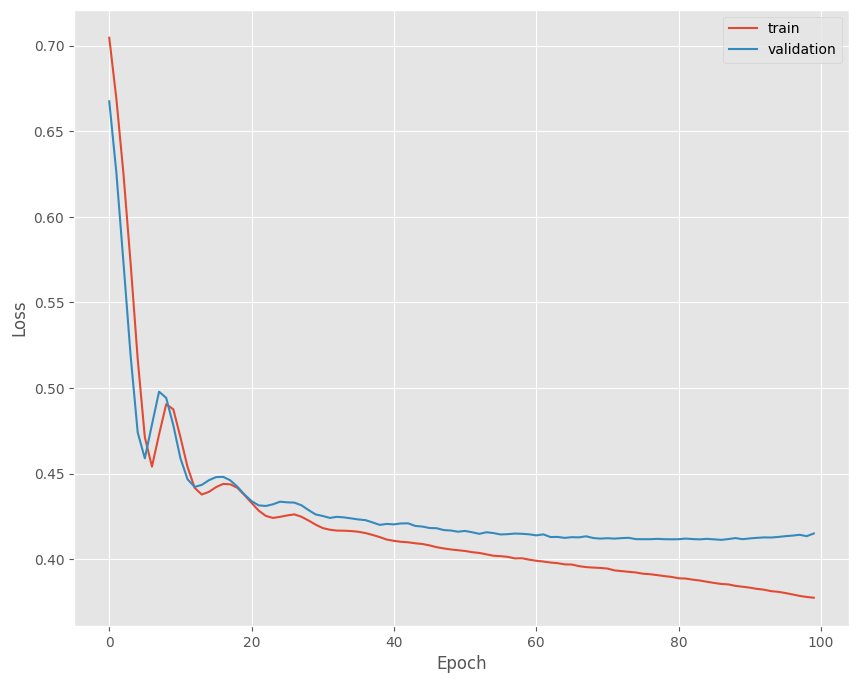

In [85]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [86]:
logits = model(X_w_test, X_d_test)
probs = torch.sigmoid(logits)
test_prediction=(probs > 0.5).float()

print(classification_report(label_test.cpu().numpy(),test_prediction.cpu().numpy()))
print('Overall F1 Score is: ',f1_score(label_test.cpu().numpy(),test_prediction.cpu().numpy(), average='weighted' ))
print('ROC AUC socre is: ',roc_auc_score(label_test.cpu().numpy(),test_prediction.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91     16616
         1.0       0.49      0.03      0.06      3384

    accuracy                           0.83     20000
   macro avg       0.66      0.51      0.48     20000
weighted avg       0.78      0.83      0.76     20000

Overall F1 Score is:  0.7641341819647761
ROC AUC socre is:  0.5133232686942774


###### Mini-Batch Training

In [64]:
# build model

class Model(nn.Module):
    def __init__(self, wide_dim, embedding_inputs, hidden_layers, dropout_p=0.7):
        super().__init__()
        self.wide_dim = wide_dim
        self.embedding_inputs = embedding_inputs
        self.deep_feature_dim = 0
        self.hidden_layers = hidden_layers

        # For each deep feature, create an embedding layer to convert them to embeddings
        for embedding_input in self.embedding_inputs:
            col_name, vocab_size, embed_dim = embedding_input.split('SEP')
            #print(col_name, vocab_size, embed_dim)
            setattr(self, col_name+'_emb_layer', nn.Embedding(int(vocab_size), int(embed_dim)))
            #Note: nn.Embedding(input_dimension, embedding_dimension), convert each device model ID (an int from 0 to 3119) into a 256-dimensional vector.
            #Note: setattr()-useful when creating many embedding layers in a loop; equal to self.device_model_emb_layer = nn.Embedding(4380, 256)
            self.deep_feature_dim += int(embed_dim)

        # A series of hidden layers that take the embeddings as input
        self.linear_layer_1 = nn.Linear(self.deep_feature_dim, self.hidden_layers[0])
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        #Note: Batch normalization, make sure each feature is normally distributed.(mean=0, variance=1)
        for i, hidden_layer in enumerate(self.hidden_layers[1:]):
            setattr(self, f'linear_layer_{i+2}', nn.Linear(self.hidden_layers[i], hidden_layer))

        self.dropout = nn.Dropout(p=0.5) #drop out probability for wide layer
        #Note: During training, 70% of the neurons passed into this layer will be randomly set to zero
        #      at each forward pass. Commonly used values are 0.2~0.5

        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim+self.hidden_layers[-1], 1)


    def forward(self, X_w, X_d):
        embeddings = [getattr(self, col_name+'_emb_layer')(X_d[:, i].long()) #Access corresponding embedding layer self.device_model_emb_layer & column X_d[:, i], converts it to long (required for embeddings).
                      for i, embedding_input in enumerate(self.embedding_inputs)
                      for col_name in embedding_input.split('SEP')
                      if not col_name.isdigit() #Get embedding column name: eg."device_model"
                     ]

        deep_out = torch.cat(embeddings, dim=-1)
        # concatenate the embeddings of all deep features
        # concatenates all the embedding outputs along the last dimension

        for i, _ in enumerate(self.hidden_layers):
            deep_out = F.relu(getattr(self, f'linear_layer_{i+1}')(deep_out))

        X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        out = self.fc(fc_input)

        return out

In [101]:
def train_with_batches(actual_train_data,loss_func_to_use='BCE'):
  model = Model(wide_dim=WIDE_DIM,
              embedding_inputs=EMBEDDING_INPUTS,
              hidden_layers=[256,128,64],#[512, 256, 128],
              dropout_p=0.7)
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)
  if loss_func_to_use=='BCE':
    loss_fn = nn.BCEWithLogitsLoss()
  elif loss_func_to_use=='Focal':
    loss_fn=FocalLoss(alpha=0.72,gamma=2)
#Note: It’s commonly used in binary classification tasks (e.g., predicting CTR),
#      where the model outputs a single logit (real number), and want to predict either 0 or 1.
#      loss function in PyTorch that combines: Sigmoid activation & Binary Cross-Entropy (BCE) loss

  scaler=torch.amp.GradScaler()
#scaler = torch.cuda.amp.GradScaler()
#Note: enable automatic mixed precision training in PyTorch, improving training speed and
#      memory efficiency on GPUs, while maintaining accuracy

  best_val_loss = float('inf')
  train_losses = []
  test_losses = []

# training
  X_w_train = torch.tensor(actual_train_data.iloc[:][w_feature].values.astype(np.float32)) #train.iloc[:][w_feature].values.shape=(80000,472)
  X_w_train = X_w_train.squeeze().to(device)
#Note: .squeeze()--Removes dimensions of size 1. (e.g., [80000, 1] → [80000])
  X_d_train = torch.tensor(actual_train_data.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
  X_d_train = X_d_train.squeeze().to(device)
  label_train = torch.tensor(actual_train_data['click'].values.astype(np.float32)).to(device)
  label_train = label_train.squeeze().unsqueeze(1).to(device)
#Note: .unsqueeze(1)--Adds a new dimension at position 1 (i.e., makes it a column vector).
#      Final shape: [80000, 1], required by binary classification models like BCEWithLogitsLoss.
#--------------------------------------------------------------------------------------------------

# testing
  X_w_test = torch.tensor(test.iloc[:][w_feature].values.astype(np.float32))
  X_w_test = X_w_test.squeeze().to(device)
  X_d_test = torch.tensor(test.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
  X_d_test = X_d_test.squeeze().to(device)
  label_test = torch.tensor(test['click'].values.astype(np.float32)).to(device)
  label_test = label_test.squeeze().unsqueeze(1).to(device)

#--------------------------------------------------------------------------------------------------
# Creat datasets and dataloader
  train_dataset = TensorDataset(X_w_train, X_d_train, label_train)
  test_dataset = TensorDataset(X_w_test, X_d_test, label_test)

  batch_size = 64 #512

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

#--------------------------------------------------------------------------------------------------
# Training Loop
  record_all_losses_train=[]
  record_all_losses_test=[]
  for epoch in range(5):
      model.train()
      total_loss_train = 0

      for batch_idx, (Xw_batch, Xd_batch, y_batch) in enumerate(train_loader):
          y_pred_train = model(Xw_batch, Xd_batch)
          loss_train = loss_fn(y_pred_train, y_batch)

          optimizer.zero_grad()
          scaler.scale(loss_train).backward()
          scaler.step(optimizer)
          scaler.update()

          total_loss_train += loss_train.item()
          record_all_losses_train.append(loss_train.item())

      avg_loss_train = total_loss_train / len(train_loader)
      train_losses.append(avg_loss_train)


      model.eval()
      with torch.no_grad():
          total_loss_test = 0
          for Xw_batch, Xd_batch, y_batch in test_loader:
              y_pred_test = model(Xw_batch, Xd_batch)
              loss_test = loss_fn(y_pred_test, y_batch)
              total_loss_test += loss_test.item()
              record_all_losses_test.append(loss_test.item())

          avg_loss_test = total_loss_test / len(test_loader)
          test_losses.append(avg_loss_test)


      print(f'=============== Epoch {epoch} ===============')
      print('epoch:', epoch, 'Training Loss:', avg_loss_train)
      print('epoch:', epoch, 'testing Loss:', avg_loss_test)

      if test_losses[-1] < best_val_loss:
          best_val_loss = test_losses[-1]
        # print('Best model saved.\n')
        # torch.save(model.state_dict(), './saved_model.pt')
  return model, train_losses, test_losses



In [ ]:
model = Model(wide_dim=WIDE_DIM,
              embedding_inputs=EMBEDDING_INPUTS,
              hidden_layers=[256,128,64],#[512, 256, 128],
              dropout_p=0.7)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCEWithLogitsLoss()
#Note: It’s commonly used in binary classification tasks (e.g., predicting CTR),
#      where the model outputs a single logit (real number), and want to predict either 0 or 1.
#      loss function in PyTorch that combines: Sigmoid activation & Binary Cross-Entropy (BCE) loss

scaler=torch.amp.GradScaler()
#scaler = torch.cuda.amp.GradScaler()
#Note: enable automatic mixed precision training in PyTorch, improving training speed and
#      memory efficiency on GPUs, while maintaining accuracy

best_val_loss = float('inf')
train_losses = []
test_losses = []

# training
X_w_train = torch.tensor(train.iloc[:][w_feature].values.astype(np.float32)) #train.iloc[:][w_feature].values.shape=(80000,472)
X_w_train = X_w_train.squeeze().to(device)
#Note: .squeeze()--Removes dimensions of size 1. (e.g., [80000, 1] → [80000])
X_d_train = torch.tensor(train.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_train = X_d_train.squeeze().to(device)
label_train = torch.tensor(train['click'].values.astype(np.float32)).to(device)
label_train = label_train.squeeze().unsqueeze(1).to(device)
#Note: .unsqueeze(1)--Adds a new dimension at position 1 (i.e., makes it a column vector).
#      Final shape: [80000, 1], required by binary classification models like BCEWithLogitsLoss.
#--------------------------------------------------------------------------------------------------

# testing
X_w_test = torch.tensor(test.iloc[:][w_feature].values.astype(np.float32))
X_w_test = X_w_test.squeeze().to(device)
X_d_test = torch.tensor(test.iloc[:][EMBEDDING_INPUTS1].values.astype(np.float32))
X_d_test = X_d_test.squeeze().to(device)
label_test = torch.tensor(test['click'].values.astype(np.float32)).to(device)
label_test = label_test.squeeze().unsqueeze(1).to(device)

#--------------------------------------------------------------------------------------------------
# Creat datasets and dataloader
train_dataset = TensorDataset(X_w_train, X_d_train, label_train)
test_dataset = TensorDataset(X_w_test, X_d_test, label_test)

batch_size = 64 #512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#--------------------------------------------------------------------------------------------------
# Training Loop
record_all_losses_train=[]
record_all_losses_test=[]
for epoch in range(5):
    model.train()
    total_loss_train = 0

    for batch_idx, (Xw_batch, Xd_batch, y_batch) in enumerate(train_loader):
        y_pred_train = model(Xw_batch, Xd_batch)
        loss_train = loss_fn(y_pred_train, y_batch)

        optimizer.zero_grad()
        scaler.scale(loss_train).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss_train += loss_train.item()
        record_all_losses_train.append(loss_train.item())

    avg_loss_train = total_loss_train / len(train_loader)
    train_losses.append(avg_loss_train)


    model.eval()
    with torch.no_grad():
        total_loss_test = 0
        for Xw_batch, Xd_batch, y_batch in test_loader:
            y_pred_test = model(Xw_batch, Xd_batch)
            loss_test = loss_fn(y_pred_test, y_batch)
            total_loss_test += loss_test.item()
            record_all_losses_test.append(loss_test.item())

        avg_loss_test = total_loss_test / len(test_loader)
        test_losses.append(avg_loss_test)


    print(f'=============== Epoch {epoch} ===============')
    print('epoch:', epoch, 'Training Loss:', avg_loss_train)
    print('epoch:', epoch, 'testing Loss:', avg_loss_test)

    if test_losses[-1] < best_val_loss:
        best_val_loss = test_losses[-1]
        # print('Best model saved.\n')
        # torch.save(model.state_dict(), './saved_model.pt')


plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [96]:
model, train_losses, test_losses = train_with_batches(train,'BCE')

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.41503963259458543
epoch: 0 testing Loss: 0.4115224712477705
=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.4037130518555641
epoch: 1 testing Loss: 0.40603545708016464
=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.4001894849061966
epoch: 2 testing Loss: 0.40726438902627926
=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.39724771897792815
epoch: 3 testing Loss: 0.40565794653976306
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.3947900123953819
epoch: 4 testing Loss: 0.40928254064660485


In [97]:
logits = model(X_w_test, X_d_test)
probs = torch.sigmoid(logits)
test_prediction=(probs > 0.5).float()

print(classification_report(label_test.cpu().numpy(),test_prediction.cpu().numpy()))
print('Overall F1 Score is: ',f1_score(label_test.cpu().numpy(),test_prediction.cpu().numpy(), average='weighted' ))
print('ROC AUC socre is: ',roc_auc_score(label_test.cpu().numpy(),test_prediction.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     16616
         1.0       0.73      0.01      0.02      3384

    accuracy                           0.83     20000
   macro avg       0.78      0.50      0.46     20000
weighted avg       0.81      0.83      0.76     20000

Overall F1 Score is:  0.7578687037311845
ROC AUC socre is:  0.5047802055838402


##### Fix data imbalance problem

###### Method 1: upsampling training data

In [89]:
from sklearn.utils import resample

In [90]:
# Separate majority and minority classes
df_majority = train[train['click'] == 0]
df_minority = train[train['click'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority
                                 random_state=42)

# Combine back
train_balanced = pd.concat([df_majority, df_minority_upsampled])

In [98]:
model, train_losses, test_losses = train_with_batches(train_balanced,'BCE')

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.6033256377378338
epoch: 0 testing Loss: 0.6081729509388677
=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.5713175188460721
epoch: 1 testing Loss: 0.5852636957701783
=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.5501367621630973
epoch: 2 testing Loss: 0.6085173912322559
=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.5320125376503854
epoch: 3 testing Loss: 0.6125814931842085
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.5148321492874268
epoch: 4 testing Loss: 0.6028849663444982


In [99]:
logits = model(X_w_test, X_d_test)
probs = torch.sigmoid(logits)
test_prediction=(probs > 0.5).float()

print(classification_report(label_test.cpu().numpy(),test_prediction.cpu().numpy()))
print('Overall F1 Score is: ',f1_score(label_test.cpu().numpy(),test_prediction.cpu().numpy(), average='weighted' ))
print('ROC AUC socre is: ',roc_auc_score(label_test.cpu().numpy(),test_prediction.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.90      0.65      0.76     16616
         1.0       0.27      0.64      0.39      3384

    accuracy                           0.65     20000
   macro avg       0.59      0.65      0.57     20000
weighted avg       0.79      0.65      0.69     20000

Overall F1 Score is:  0.69475653412269
ROC AUC socre is:  0.6488453978107631


Insight\
Recall for class 1 improved drastically (from 0.04 → 0.70).

Accuracy dropped to 63%, but this is expected because the model now focuses more on detecting the minority class (1).

ROC AUC of 0.66 indicates your model is now better at distinguishing between classes.

F1 Score improved from 0.07 → 0.39 for class 1, and overall to 0.68 — a much healthier signal.

###### Method 2: Using SMOTE

In [105]:
from imblearn.over_sampling import SMOTE

In [106]:
x_train=train.drop('click',axis=1)
y_train=train['click']

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

#Get train_resampled_data:
train_resampled=pd.concat([X_train_resampled,y_train_resampled],axis=1)

In [108]:
model, train_losses, test_losses = train_with_batches(train_resampled,'BCE')

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.488304304653709
epoch: 0 testing Loss: 0.5433372735215453
=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.4239497480990788
epoch: 1 testing Loss: 0.506147534131242
=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.4115717705564211
epoch: 2 testing Loss: 0.4494170432273572
=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.4056485420234023
epoch: 3 testing Loss: 0.46203353258367547
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.39930629355195385
epoch: 4 testing Loss: 0.5064675437566191


In [110]:
logits = model(X_w_test, X_d_test)
probs = torch.sigmoid(logits)
test_prediction=(probs > 0.5).float()

print(classification_report(label_test.cpu().numpy(),test_prediction.cpu().numpy()))
print('Overall F1 Score is: ',f1_score(label_test.cpu().numpy(),test_prediction.cpu().numpy(), average='weighted' ))
print('ROC AUC socre is: ',roc_auc_score(label_test.cpu().numpy(),test_prediction.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85     16616
         1.0       0.33      0.40      0.36      3384

    accuracy                           0.76     20000
   macro avg       0.60      0.62      0.61     20000
weighted avg       0.78      0.76      0.77     20000

Overall F1 Score is:  0.7687472485110055
ROC AUC socre is:  0.6153211436525905


Insights:\
SMOTE improves recall & F1 of class 1 (positive) significantly over the original (recall: 0.04 → 0.40).

Accuracy drops slightly from 0.83 to 0.76 — expected when focusing more on minority class.

SMOTE recall is lower than basic upsampling (0.40 vs. 0.70), but accuracy and F1 are better balanced.

ROC AUC with SMOTE is lower than upsampling (0.62 vs. 0.66), possibly due to synthetic data noise.

###### Method 3: Use Focal loss

In [100]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [103]:
model, train_losses, test_losses = train_with_batches(train,'Focal')

=============== Epoch 0 ===============
epoch: 0 Training Loss: 0.0786112057954073
epoch: 0 testing Loss: 0.07756431618580423
=============== Epoch 1 ===============
epoch: 1 Training Loss: 0.07671263246834278
epoch: 1 testing Loss: 0.07771561781581217
=============== Epoch 2 ===============
epoch: 2 Training Loss: 0.07611587073504925
epoch: 2 testing Loss: 0.07621839986489223
=============== Epoch 3 ===============
epoch: 3 Training Loss: 0.07581942164003849
epoch: 3 testing Loss: 0.07638924176129289
=============== Epoch 4 ===============
epoch: 4 Training Loss: 0.0752673344373703
epoch: 4 testing Loss: 0.07596043924601695


In [104]:
logits = model(X_w_test, X_d_test)
probs = torch.sigmoid(logits)
test_prediction=(probs > 0.5).float()

print(classification_report(label_test.cpu().numpy(),test_prediction.cpu().numpy()))
print('Overall F1 Score is: ',f1_score(label_test.cpu().numpy(),test_prediction.cpu().numpy(), average='weighted' ))
print('ROC AUC socre is: ',roc_auc_score(label_test.cpu().numpy(),test_prediction.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     16616
         1.0       0.63      0.04      0.08      3384

    accuracy                           0.83     20000
   macro avg       0.73      0.52      0.50     20000
weighted avg       0.80      0.83      0.77     20000

Overall F1 Score is:  0.7687258692925201
ROC AUC socre is:  0.5192195622209247
